In [5]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import imageio
from scipy import signal

import timeit

In [144]:
input_img = os.path.abspath('./figures/cat-color.png') # Путь к изображению

In [241]:
def scharr_filter():
    return np.array([[ -3-3j, 0-10j,  +3 -3j],
                    [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]])
  
def sobel_filter():
    return np.array([[ -1-1j, 0- 2j,  +1 -1j],
                   [ -2+0j, 1+ 0.5j,  +2 +0j],
                   [ -1+1j, 0+ 2j,  +1 +1j]])
  
def laplace_filter():
    return np.array([[ 0+0j,  0+1j,  0+0j],
                   [ 1+0j, -2-2j,  1+0j],
                   [ 0+0j,  0+1j,  0+0j]])
  
def gause_blur():
    win_size = (11, 11)
    sigma = 3
    w = np.zeros(win_size, dtype=np.float32)
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            w[i,j] = np.exp(-(i-w.shape[0]//2)**2 / sigma**2 / 2 
                            -(j-w.shape[1]//2)**2 / sigma**2 / 2)
    return  w / np.sum(w)

In [242]:
class ImageTransformation:
  org_img = None
  res_img = None
  org_path = ''

  def __init__(self, path=None):
    if path is not None:
      self.init_transform(path)

  def init_transform(self, path):
    try:
      self.res_img = None
      self.org_path = path
      self.org_img = imageio.imread(path)
    except IOError:
      print(f'Файл {path} не удалось прочитать')
      self.org_img = None
      self.res_img = None
      self.img_filter = None

  def transorm_with_scipy(self, new_filter=None, threshold=None):
    grad = self.gray_image() / 255
    for img_filter in new_filter:
      grad = signal.convolve2d(grad, img_filter, boundary='symm', mode='same')
    if threshold is None:
      self.res_img = grad
    else:
      self.res_img = (threshold[1] <= np.angle(grad) / np.pi).astype(np.uint8) + (threshold[0] >= np.angle(grad) / np.pi).astype(np.uint8) 

  def transorm_with_numpy(self, new_filter=None, threshold=None):
    gray_img = self.gray_image()/ 255

    for img_filter in new_filter:
      grad = np.zeros(
      (gray_img.shape[0] - img_filter.shape[0] + 1,
      gray_img.shape[1] - img_filter.shape[1] + 1),
      dtype = 'complex_')   

      for i in range(grad.shape[0]):
          for j in range(grad.shape[1]):
              x = gray_img[i:i+img_filter.shape[0], j:j+img_filter.shape[1]]
              grad[i,j] = np.sum(img_filter * x)
      gray_img = grad.copy()
    if threshold is None:
      self.res_img = grad
    else:
      self.res_img = (threshold[1] <= np.angle(gray_img)/ np.pi).astype(np.uint8) + (threshold[0] >= np.angle(gray_img)/ np.pi).astype(np.uint8)

  def show_original_image(self, ax, title='Original'):
     if self.org_img is None:
        pass
     else:
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow(self.org_img)    

  def show_gray_image(self, ax, title='Gray'):
    if self.org_img is None:
        pass
    else:
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow(self.gray_image(), cmap='gray')

  def show_tranformed_image(self, ax, mode='scipy', new_filter=None, reload_image=True, title=None, threshold=None):
    try:
      if (self.res_img is None or reload_image or new_filter is not None) and mode=='scipy':
          self.transorm_with_scipy(new_filter=new_filter, threshold=threshold)
      elif (self.res_img is None or reload_image or new_filter is not None) and mode=='numpy':
          self.transorm_with_numpy(new_filter=new_filter, threshold=threshold)

      ax.set_title(f'{title}({mode})')
      ax.set_axis_off()
      ax.imshow(self.res_img, cmap='gray') 
    except TypeError:
      print(f'Не удалось применить фильтр. Mode={mode}')

  def gray_image(self):
    return np.mean(self.org_img, axis=2)

In [243]:
def image_transform(img_transform):
    fig, (ax_orig, ax_schar, ax_sobel, ax_laplace) = plt.subplots(4, 3, figsize=(15, 15))
    img_transform.show_original_image(ax_orig[0])
    img_transform.show_gray_image(ax_orig[1])
    img_transform.show_tranformed_image(ax_orig[2], new_filter=[gause_blur()], title = 'gause_blur')
    img_transform.show_tranformed_image(ax_sobel[0], new_filter=[sobel_filter()], title = 'Sobel Modified', threshold=(0.1, 0.9))
    img_transform.show_tranformed_image(ax_sobel[1], new_filter=[sobel_filter()], title = 'Sobel Modified', threshold=(0.1, 0.9), mode='numpy')
    img_transform.show_tranformed_image(ax_sobel[2], new_filter=[gause_blur(), sobel_filter()], title = 'Gause+Sobel', threshold=(0.1, 0.9))
    img_transform.show_tranformed_image(ax_schar[0], new_filter=[scharr_filter()], title = 'Scharr', threshold=(0.1, 0.9))
    img_transform.show_tranformed_image(ax_schar[1], new_filter=[scharr_filter()], title = 'Scharr', threshold=(0.1, 0.9), mode='numpy')
    img_transform.show_tranformed_image(ax_schar[2], new_filter=[gause_blur(), scharr_filter()], title = 'Gause+Scharr', threshold=(0.1, 0.9))
    img_transform.show_tranformed_image(ax_laplace[0], new_filter=[laplace_filter()], title = 'Laplace', threshold=(0.1, 0.9))
    img_transform.show_tranformed_image(ax_laplace[1], new_filter=[laplace_filter()], title = 'Laplace', threshold=(0.1, 0.9), mode='numpy')
    img_transform.show_tranformed_image(ax_laplace[2], new_filter=[laplace_filter(), sobel_filter()], title = 'Laplace+Sobel', threshold=(0.1, 0.9))
    fig.show()

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


Wall time: 9.96 s


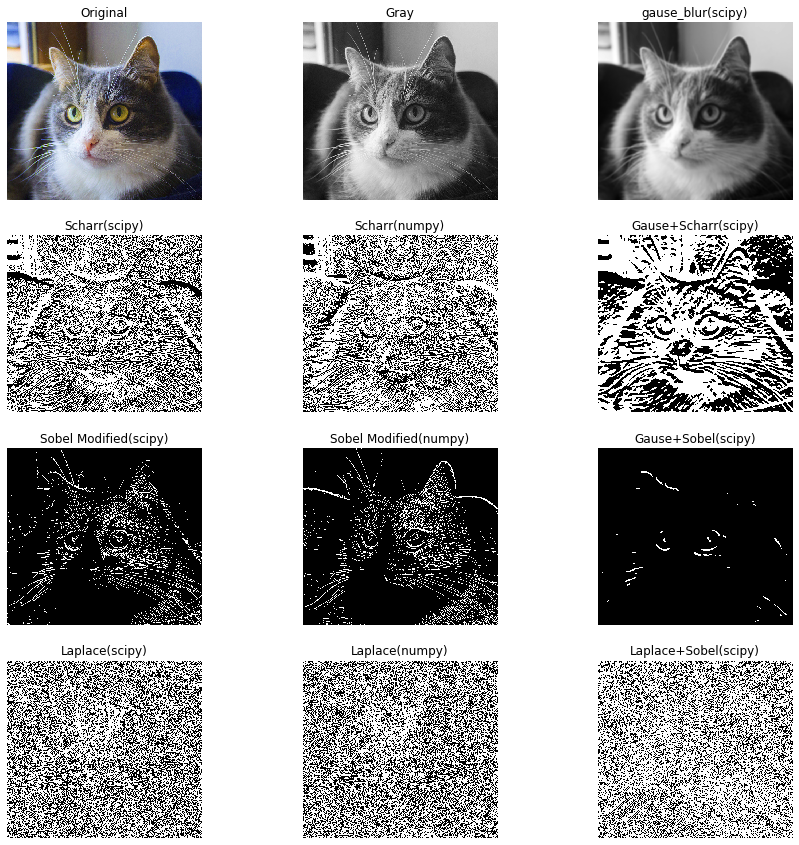

In [246]:
%%time

# ядро (1+ 1j)
def sobel_filter():
    return np.array([[ -1-1j, 0- 2j,  +1 -1j],
                   [ -2+0j, 1+ 1j,  +2 +0j],
                   [ -1+1j, 0+ 2j,  +1 +1j]])


image_transform(ImageTransformation(input_img))

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


Wall time: 10.1 s


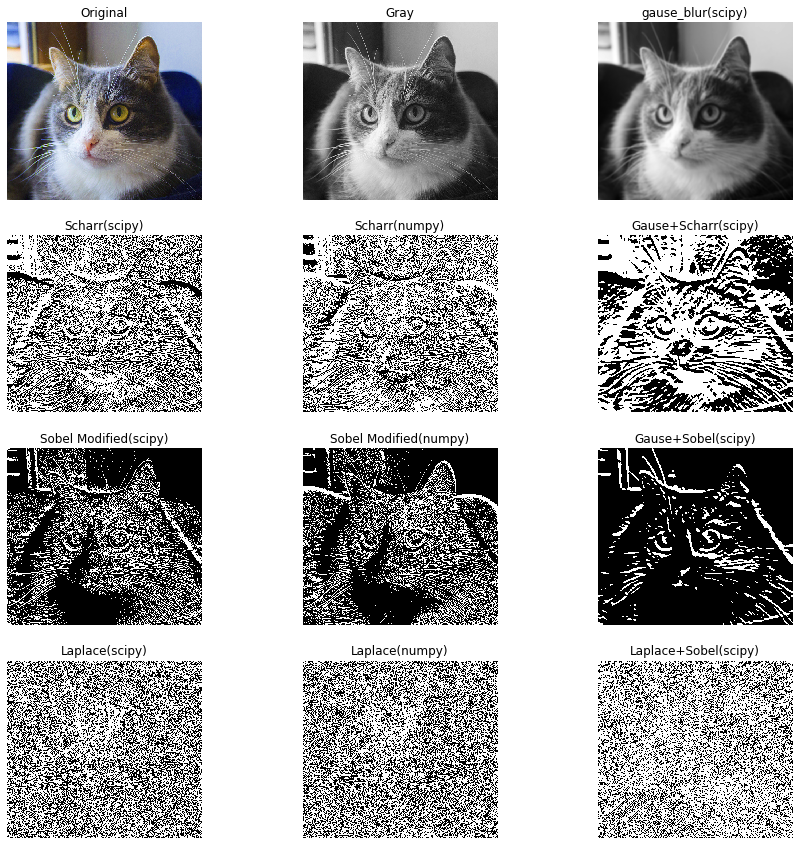

In [245]:
%%time

# ядро (1+ 0.5j)

def sobel_filter():
    return np.array([[ -1-1j, 0- 2j,  +1 -1j],
                   [ -2+0j, 1+ 0.5j,  +2 +0j],
                   [ -1+1j, 0+ 2j,  +1 +1j]])

image_transform(ImageTransformation(input_img))

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


Wall time: 9.75 s


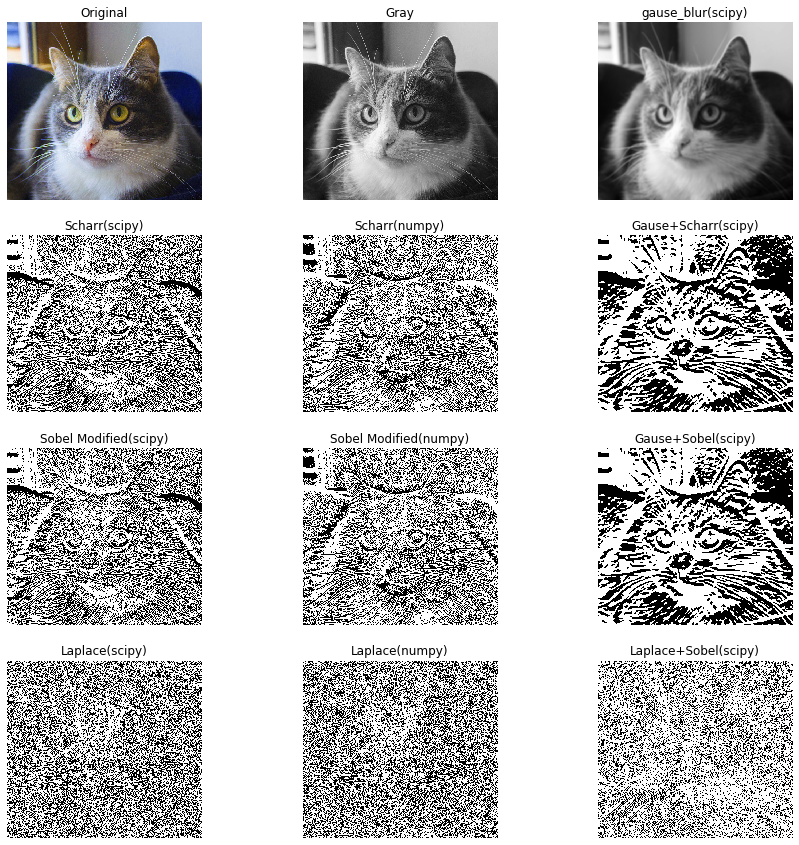

In [249]:
%%time

# Базовый пример
def sobel_filter():
    return np.array([[ -1-1j, 0- 2j,  +1 -1j],
                   [ -2+0j, 0+ 0j,  +2 +0j],
                   [ -1+1j, 0+ 2j,  +1 +1j]])

image_transform(ImageTransformation(input_img))